# Data import

In [6]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [7]:

conn_string = "host='localhost' dbname='weather_env' user='postgres' password='postgres'"
conn = psycopg2.connect(conn_string)
cur = conn.cursor()
cur.execute("""SELECT * FROM environment_data.pivoted;""")
records = cur.fetchall()
cur.close()
df = pd.DataFrame(records, columns=[x[0] for x in cur.description])
df.index = pd.to_datetime(df[['measure_year', 'measure_month', 'measure_day']].rename({'measure_year': 'year', 'measure_month': 'month', 'measure_day': 'day'}, axis=1))

# Similar Weeks

In [ ]:
gdf = df[['arnhem_waterlevel']]\
    .groupby([df.index.year.astype(str) + '_' + df.index.isocalendar().week.astype(str).str.zfill(2), df.index.weekday])\
    .mean().unstack(level=1).sort_index().iloc[:-1]
gdf

In [ ]:
cdf = gdf.T.corr()['2022_10'].sort_values(ascending=False).dropna()
cdf

In [ ]:
def next_week(week):
    year, week = week.split('_')
    year, week = int(year), int(week)
    if week == 53:
        year += 1
        week = 1
    else:
        week += 1
    _next = f'{year}_{week}'
    return _next

old = cdf.head(15).index
new = list(map(next_week, old))
list(zip(old, new))

In [ ]:
gdf.loc[[x for x in map(next_week, old) if x in gdf.index]].T.plot()

# Similar `n` days

In [8]:
subset = df['arnhem_waterlevel'].values
ndays = 14
gdf = pd.DataFrame([subset[a:b] for a, b in enumerate(range(ndays, subset.shape[0]))]).dropna()
gdf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1209.0,1201.0,1195.0,1190.0,1175.0,1169.0,1154.0,1135.0,1112.0,1088.0,1046.0,1018.0,1004.0,991.0
1,1201.0,1195.0,1190.0,1175.0,1169.0,1154.0,1135.0,1112.0,1088.0,1046.0,1018.0,1004.0,991.0,989.0
2,1195.0,1190.0,1175.0,1169.0,1154.0,1135.0,1112.0,1088.0,1046.0,1018.0,1004.0,991.0,989.0,1020.0
3,1190.0,1175.0,1169.0,1154.0,1135.0,1112.0,1088.0,1046.0,1018.0,1004.0,991.0,989.0,1020.0,1018.0
4,1175.0,1169.0,1154.0,1135.0,1112.0,1088.0,1046.0,1018.0,1004.0,991.0,989.0,1020.0,1018.0,1012.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92342,775.5,785.7,804.3,819.7,836.2,832.3,831.8,828.8,835.5,831.8,831.8,827.2,827.3,827.8
92343,785.7,804.3,819.7,836.2,832.3,831.8,828.8,835.5,831.8,831.8,827.2,827.3,827.8,830.6
92344,804.3,819.7,836.2,832.3,831.8,828.8,835.5,831.8,831.8,827.2,827.3,827.8,830.6,825.8
92345,819.7,836.2,832.3,831.8,828.8,835.5,831.8,831.8,827.2,827.3,827.8,830.6,825.8,814.4


In [27]:
def corr(a, b):
    a = (a - np.mean(a))/(np.std(a)*len(a))
    b = (b - np.mean(b))/(np.std(b))
    return np.correlate(a, b)[0]

In [77]:
def corr(a, b, sample=True, full=False):
    _c = (np.matmul(a - a.mean(), b - b.mean()) / (a.size - (1 if sample else 0))) / (a.std() * b.std())
    _m = (a.mean() / b.mean()) / (a.std() / b.std())
    if full:
        return _c , _m, _c * _m
    else:
        return _c * _m

corr(gdf.iloc[91922], gdf.iloc[54], False, True)

(0.0626094029566575, 7.5418192470410395, 0.4721888002642677)

In [79]:
month_num = gdf.shape[0]-100
print(month_num)
val = gdf.loc[month_num]
cdf = pd.Series([corr(val, x) for _, x in gdf[:100].iterrows()]).abs().sort_values(ascending=False).dropna()
cdf

91922


54    2.193755
61    2.169029
53    2.042051
60    2.031105
48    2.024212
        ...   
34    0.127596
29    0.088917
97    0.066073
16    0.063549
0     0.058342
Length: 100, dtype: float64

In [58]:
cdf_head = cdf[cdf>.99].head(30).dropna()
likely = cdf_head.min()
ind = cdf_head.index + ndays
result = gdf.loc[[x for x in ind if x in gdf.index]].sort_index().T
nlikely = result.shape[1]
title = f'The results of the {ndays} days after the {nlikely} most similar {ndays} day periods (more than {likely:.1%} similarity)'
title

'The results of the 14 days after the 30 most similar 14 day periods (more than 122.3% similarity)'

Text(0.5, 1.0, 'The results of the 14 days after the 30 most similar 14 day periods (more than 122.3% similarity)')

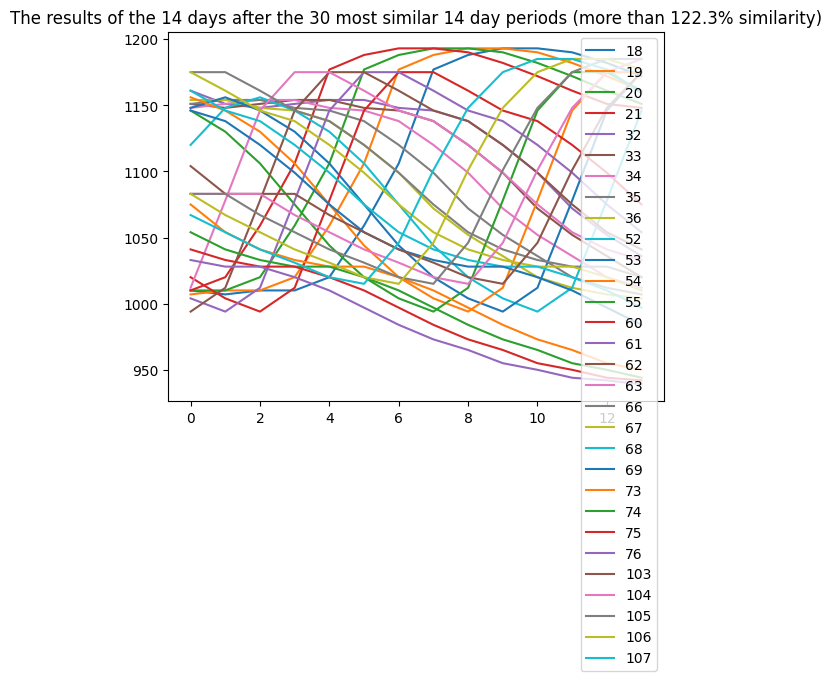

In [59]:
result.plot()
plt.title(title)

Text(0.5, 1.0, 'The results of the 14 days after the 30 most similar 14 day periods (more than 122.3% similarity)')

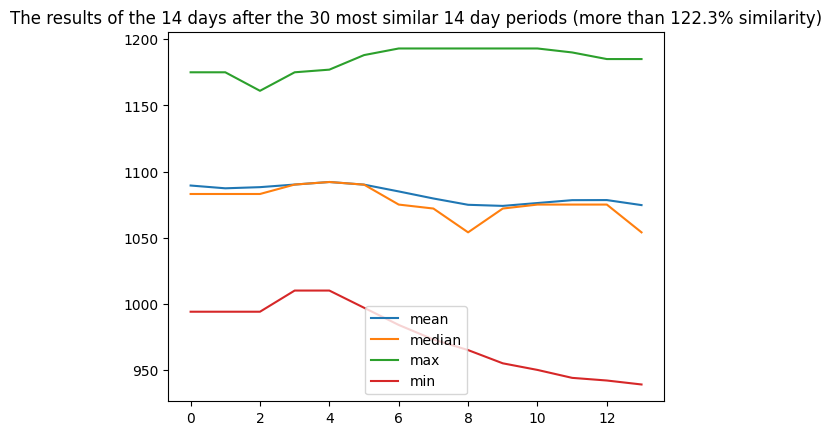

In [60]:
sub = result.copy()
sub['mean'] = sub.mean(axis=1)
sub['median'] = sub.median(axis=1)
sub['max'] = sub.max(axis=1)
sub['min'] = sub.min(axis=1)
sub[['mean', 'median', 'max', 'min',]].plot()
plt.title(title)

Text(0.5, 1.0, 'The results of the 14 days after the 30 most similar 14 day periods (more than 122.3% similarity)')

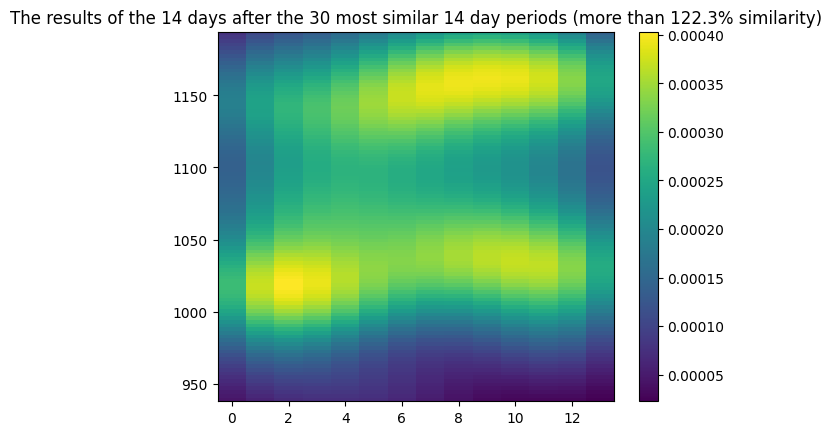

In [61]:
from scipy.stats import gaussian_kde

x = pd.MultiIndex.from_product([result.columns, result.index]).get_level_values(1)
y = result.values.flatten()

ybins = 100
k = gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():ndays*1j, y.min():y.max():ybins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
plt.colorbar()
plt.title(title)

Text(0.5, 1.0, 'The results of the 14 days after the 30 most similar 14 day periods (more than 122.3% similarity)')

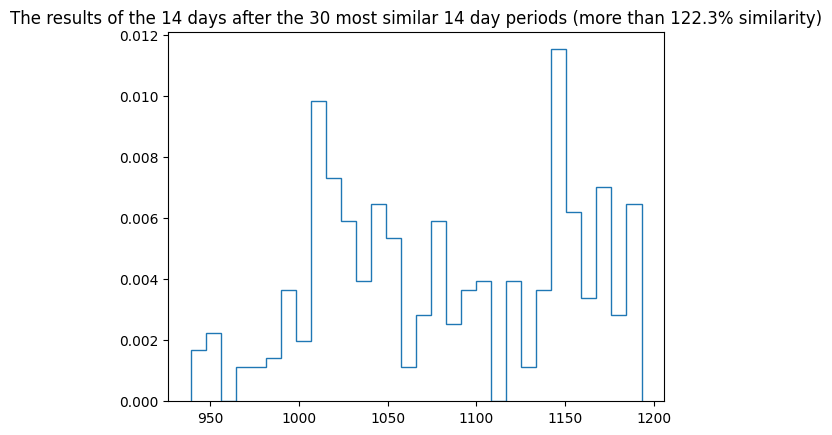

In [62]:
y = result.values.flatten()
plt.hist(y, 30, density=True, histtype='step')
plt.title(title)